# Lab3 
# Generative or Discriminative? Getting the Best of Both Worlds

## Reporter:  Kovaleva Maria

## Task
Repeat experiment from Bishop's article (fig. 4) with naive implementation of generative-discriminative model. Visualize discriminative surface as an interactive plot dependent on the number of labeled objects and coefficients for each term. 

Article: https://www.microsoft.com/en-us/research/wp-content/uploads/2016/05/Bishop-Valencia-07.pdf

## Theory

A generative model can be defined by specifying the joint distribution $p(x, c|\theta)$ of the input vector $x$ and the class label $c$, conditioned on a set of parameters $\theta$.
Typically this is done by defining a prior probability for the classes $p(c|\pi)$ along with a class-conditional density for each class $p(x|c,\lambda)$, so that $p(x, c|\theta) = p(c|\pi)p(x|c,\lambda)$, where $\theta = \{\pi,\lambda\}$.


 Since the data points are assumed to be independent, the joint distribution is given by $L_G(\theta) = p(X, C, \theta) = p(\theta) \prod_{n=1}^N p(x_n, c_n|\theta)$. This can be maximized to determine the most probable (MAP) value of $\theta$. Again, since $p(X, C, \theta) = p(\theta|X, C)p(X, C)$, this is equivalent to maximizing the posterior distribution $p(\theta|X, C)$. 
 
 In order to improve the predictive performance of generative models it has been proposed to use "discriminative training" which involves maximizing $L_D(\theta) = p(C, \theta|X) = p(\theta) \prod_{n=1}^N p(c_n|x_n, \theta)$ in which we are conditioning on the input vectors instead of modelling their distribution. Here we have used $p(c|x, \theta) = \frac{p(x, c|\theta)}{\sum_{c'}p(x, c'| \theta)}$
 
 To have the mix of generative and discriminative we need to maximaze the folowing :$ L = \alpha \ln(L_D(\theta)) + (1 − \alpha) \ln(L_G(\theta))$, where $0 \leq \alpha \leq 1$, so as to interpolate between generative ($\alpha = 0$) and discriminative ($\alpha = 1$) approaches.
 

Lets get a closer look at:
    
$$ L = \alpha \ln(L_D(\theta)) + (1 − \alpha) \ln(L_G(\theta))$$

1) $$L_D(\theta)_{labeled} = p(\theta)\prod_{labeled}p(c_n|x_n,\theta) = p(\theta)\prod_{labeled}\frac{p(x_n,c_n|\theta)}{\sum_{c'}p(x_n,c'|\theta)}$$


For labeled: $p(x,c|\theta) = p(c|\pi)p(x|c,\lambda)$

$p(x|c,\lambda) = \text{pdf}[N_c(\lambda)](x)$ - c-th normal distribution, with pframeters $\lambda$, $c_n$ - label $x_n$

$p(c|\pi)$ - categorical with parameters $\pi$

2) $$L_G(\theta)_{labeled} = p(\theta)\prod_{labeled}p(c_n,x_n|\theta) = p(\theta)\prod_{labeled}p(c_n|\pi)p(x_n|c_n,\lambda)$$ 
same as in (1)

3)  $$L_G(\theta)_{unlabeled} = p(\theta)\prod_{unlabeled}p(x_n|\theta)$$ ($p(x_n|\theta)$, but not $p(x_n, c_n|\theta)$ aswe don't know $c_n$ and will maximaze such probability despite of joint distribution)

$p(x|\theta) =  p (c=1|\pi)p(x|c,\lambda) +  p (c=0|\pi)p(x|c,\lambda) = \sum_{c'}p (c'|\pi)p(x|c',\lambda)$

4) Sum:

$\theta = [p, \mu_{1x}, \mu_{1y}, \sigma_{1x}, \sigma_{1y}, \mu_{2x}, \mu_{2y}, \sigma_{2x}, \sigma_{2y}] $ - vector of parameters

$L = \alpha \ln(L_D(\theta)) + (1 − \alpha) \ln(L_G(\theta)) =  \\
\alpha \ln p(\theta) + \alpha \sum_{labeled}\ln p(c_n|\pi)p(x_n|c_n,\lambda) - \alpha \sum_{labeled}\ln\sum_{c'}p(x_n,c'|\theta) + (1-\alpha) \ln p(\theta) + (1-\alpha)\sum_{labeled}\ln p(c_n|\pi)p(x_n|c_n,\lambda) + (1-\alpha) \ln p(\theta) + (1-\alpha) \sum_{unlabeled} \ln p(x_n|\theta) = \\ 
(2 - \alpha) \ln p(\theta) + \sum_{labeled} \ln p(c_n|\pi)p(x_n|c_n,\lambda) - \alpha \sum_{labeled}\ln \sum_{c'}p(c'|\pi)p(x_n|c',\lambda) +  \\(1-\alpha) \sum_{unlabeled}\ln \left(\sum_{c'}p (c'|\pi)p(x|c',\lambda)\right)$

Then:
$\sum_{labeled} \ln p(c_n|\pi)p(x_n|c_n,\lambda) - \alpha \sum_{labeled}\ln \sum_{c'}p(c'|\pi)p(x_n|c',\lambda) +  \\(1-\alpha) \sum_{unlabeled}\ln \left(\sum_{c'}p (c'|\pi)p(x|c',\lambda)\right) \rightarrow max$


In [4]:
import scipy

import numpy as np 

from ipywidgets import interact, interactive, interact_manual, fixed, widgets
from jax.scipy.stats import multivariate_normal
from jax.scipy.stats import norm

from tqdm.notebook import tqdm

from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from functools import partial
from jax import grad

import jax.numpy as jnp
from jax import random


In [5]:
n = 400
first  = np.random.multivariate_normal((3,2),   np.diag((4,0.2)), n)
second = np.random.multivariate_normal((3,3.5), np.diag((4,0.2)), n)
first_y  = np.zeros(n)
second_y = np.ones(n)

x = np.concatenate((first, second))
y = np.concatenate((first_y, second_y))

print(x.shape, y.shape)

x, y = shuffle(x, y)
x, y = jnp.array(x), jnp.array(y)

x[:5], y[:5]

(800, 2) (800,)


(DeviceArray([[1.9370816 , 1.4150723 ],
              [3.248075  , 2.5449657 ],
              [0.08408242, 2.4888108 ],
              [4.0763254 , 3.4671533 ],
              [8.026131  , 3.301403  ]], dtype=float32),
 DeviceArray([0., 1., 1., 1., 1.], dtype=float32))

In [6]:
def plot_gauss(mus, sigmas, colors):
    for m, cov, color in zip(mus, sigmas, colors):
        cov_inv = np.linalg.inv(cov)
        cov_det = np.linalg.det(cov)

        x = np.linspace(-2, 8)
        y = np.linspace(-1, 7)
        X,Y = np.meshgrid(x,y)
        coe = 1.0 / ((2 * np.pi)**2 * cov_det)**0.5
        Z = coe * np.e ** (-0.5 * (cov_inv[0,0]*(X-m[0])**2 + (cov_inv[0,1] + cov_inv[1,0])*(X-m[0])*(Y-m[1]) + cov_inv[1,1]*(Y-m[1])**2))
        plt.contour(X,Y,Z, colors = color, alpha = 0.5)

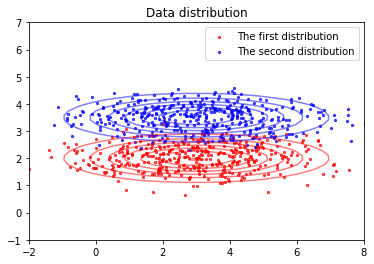

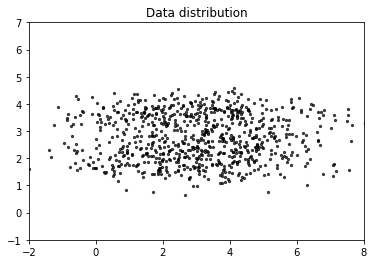

In [7]:
plot_gauss([np.array([[3],[2]]), np.array([[3],[3.5]])], 
          [np.diag((4,0.2)), np.diag((4,0.2))], 
          ["red", "blue"])

plt.scatter(first[:,0],  first[:,1],  s = 5, c = "red",  alpha = 0.7, label = 'The first distribution')
plt.scatter(second[:,0], second[:,1], s = 5, c = "blue", alpha = 0.7, label = 'The second distribution')
plt.xlim([-2, 8])
plt.ylim([-1, 7])
plt.legend()
plt.title('Data distribution')
plt.show()

plt.scatter(first[:,0],  first[:,1],  s = 5, c = "black", alpha = 0.7)
plt.scatter(second[:,0], second[:,1], s = 5, c = "black", alpha = 0.7)
plt.xlim([-2, 8])
plt.ylim([-1, 7])
plt.title('Data distribution')
plt.show()

$\sum_{labeled} \ln p(c_n|\pi) +\sum_{labeled}  \ln p(x_n|c_n,\lambda) - \alpha \sum_{labeled}\ln \sum_{c'}p(c'|\pi)p(x_n|c',\lambda) +  \\(1-\alpha) \sum_{unlabeled}\ln \left(\sum_{c'}p (c'|\pi)p(x|c',\lambda)\right) \rightarrow max$

In [8]:
y_labeled = jnp.array([0.0,1,0,1,1,1])
p = 0.3
print(y_labeled)
print(jnp.sum(jnp.log(p*(y_labeled==0) + (1-p)*(y_labeled==1))))

[0. 1. 0. 1. 1. 1.]
-3.8346455


In [19]:
def sigmoid(x):
    return 1/(1 + jnp.exp(-x))

def L(theta, x_unlabeled, x_labeled, y_labeled, alpha):
    #theta = [p, \mu_{1x}, \mu_{1y}, \sigma_{1x}, \sigma_{1y},
    #            \mu_{2x}, \mu_{2y}, \sigma_{2x}, \sigma_{2y}] 

    res = 0
    res += jnp.sum(jnp.log(sigmoid(theta[0])*(y_labeled==0) + (1-sigmoid(theta[0]))*(y_labeled==1)))
    res -= alpha *  jnp.sum(jnp.log(sigmoid(theta[0]) * multivariate_normal.pdf(x_labeled, theta[1:3], jnp.diag(jnp.exp(theta[3:5]))) + 
                           (1 - sigmoid(theta[0])) * multivariate_normal.pdf(x_labeled, theta[5:7], jnp.diag(jnp.exp(theta[7:9])))))
    res += (1 - alpha) *  jnp.sum(jnp.log(sigmoid(theta[0]) * multivariate_normal.pdf(x_unlabeled, theta[1:3], jnp.diag(jnp.exp(theta[3:5]))) + 
                           (1 - sigmoid(theta[0])) * multivariate_normal.pdf(x_unlabeled, theta[5:7], jnp.diag(jnp.exp(theta[7:9])))))
            
    for x, c in zip(x_labeled, y_labeled):
        res += multivariate_normal.logpdf(x, theta[1:3]*(c==0) + theta[5:7]*(c==1), jnp.diag(jnp.exp(theta[3:5]))*(c==0) + jnp.diag(jnp.exp(theta[7:9]))*(c==1))

    return res

In [20]:
theta0 = jnp.zeros(9)

0
[-0.0015      0.6007752   0.54819834  1.173339    0.73457444  0.6142727
  0.5585855   1.215759    0.7498689 ]
-2247.6677
1
[-0.01028657  0.7400627   0.7502612   1.3469838   0.8972431   0.76892906
  0.7778467   1.4238061   0.9263708 ]
-2027.873
2
[-0.02147154  0.8467714   0.90313184  1.4551213   0.9855832   0.8899327
  0.9464819   1.5603874   1.0213586 ]
-1917.6531
3
[-0.03312667  0.9363005   1.0311      1.5295167   1.0371828   0.99148965
  1.088143    1.6561582   1.0740006 ]
-1849.3749
4
[-0.04447278  1.0150627   1.1436151   1.5832286   1.0662745   1.0802673
  1.2127267   1.7254014   1.1003199 ]
-1801.3276
5
[-0.05528714  1.0863187   1.2453887   1.6228741   1.0799397   1.1600431
  1.3254857   1.7761306   1.1086131 ]
-1764.3594
6
[-0.06558236  1.1519561   1.3391234   1.652297    1.0822963   1.2331743
  1.429553    1.8132982   1.1037402 ]
-1733.9799
7
[-0.07546229  1.2131704   1.4265122   1.673954    1.0759947   1.3012279
  1.5269318   1.8401698   1.0887909 ]
-1707.7595
8
[-0.08505993 

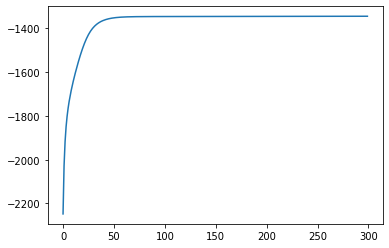

DeviceArray([-0.7305976 ,  2.620585  ,  2.3176968 ,  1.1254776 ,
             -0.46821895,  3.237019  ,  2.9856596 ,  1.3605311 ,
             -0.35348642], dtype=float32)

In [21]:
k = 100
alpha = 0.1

def optimize(theta0, x = x, y = y, k = 5, alpha = 0.5, lr = 1e-3, maxiter = 300, verbose = False):
    dL = grad(L, argnums=(0))
    dL = partial(dL,  x_unlabeled = x[k:], x_labeled = x[:k], y_labeled = y[:k], alpha = alpha)
    eps = 1e-4
    theta = theta0
    Ls = []
    for i in range(maxiter):
        if verbose:
            print(i)
        dtheta = dL(theta)
        theta += dtheta * lr
        if verbose:
          print(theta)

        Ls.append(L(theta, x[k:], x[:k], y[:k], alpha))
        if verbose:
            print(Ls[-1])
    if verbose:
        plt.plot(Ls)
        plt.show()
    return theta

optimize(theta0, lr = 0.001, verbose = True)

In [29]:
float(theta0[1])

0.0

In [55]:
len(np.array(x)[np.where(np.array(y) == 0)])

800

In [76]:
def for_interactionBishop(alpha,k): ## Соединение всего вышенаписанного в одну интерактивную функцию
    theta0 = jnp.zeros(9)
    theta = optimize(theta0, alpha = alpha, k = k, maxiter=100, lr = 0.001)
    mu_1x, mu_1y, s_1x, s_1y = float(theta[1]), float(theta[2]), float(theta[3]), float(theta[4])
    mu_2x, mu_2y, s_2x, s_2y = float(theta[5]), float(theta[6]), float(theta[7]), float(theta[8])
    mu_2, s_2 = theta[5:7], theta[7:9]
    print("p:", p, "\tmu_1: (", mu_1x, mu_1y, ")\tsigma_1: (", s_1x, s_2x, 
          ")\tmu_2: (", mu_2x, mu_2y, "\tsigma_2: (", s_2x, s_2y, ")")
    labeled_x = x[:k]
    labeled_y = y[:k]
    x_1 = np.array(labeled_x)[np.where(np.array(labeled_y) == 0)]
    x_2 = np.array(labeled_x)[np.where(np.array(labeled_y) == 1)]
    plot_gauss([np.array([[mu_1x],[mu_1y]]), np.array([[mu_2x],[mu_2y]])], 
          [np.diag((np.exp(s_1x), np.exp(s_1y))), np.diag((np.exp(s_2x), np.exp(s_2y)))], 
          ["red", "blue"])
    plt.scatter(x_1[:, 0], x_1[:, 1], marker = '+', s = 70, c = "red")
    plt.scatter(x_2[:, 0], x_2[:, 1], marker = '+', s = 70, c = "blue")
    plt.scatter(x[:, 0][k:],x[:,1][k:], marker = '.', s = 5, c = 'gray')
    plt.scatter([mu_1x,mu_2x],[mu_1y,mu_2y], marker = 'o', s=100, c = ["red", "blue"])
    plt.show()
     

k 2 	alpha 0.0
p: 0.3 	mu_1: ( 3.0064492225646973 2.7037711143493652 )	sigma_1: ( 1.313895583152771 1.3120824098587036 )	mu_2: ( 3.06854248046875 2.829892635345459 	sigma_2: ( 1.3120824098587036 -0.2779598534107208 )


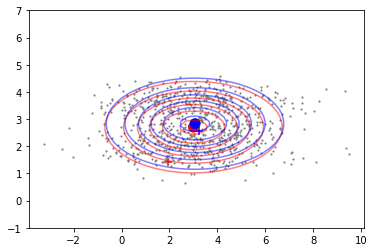

k 2 	alpha 0.1
p: 0.3 	mu_1: ( 3.0065550804138184 2.705047845840454 )	sigma_1: ( 1.3138108253479004 1.3121812343597412 )	mu_2: ( 3.0680060386657715 2.828373432159424 	sigma_2: ( 1.3121812343597412 -0.2781986892223358 )


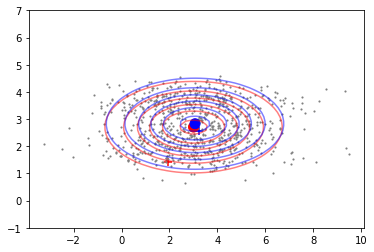

k 2 	alpha 0.3
p: 0.3 	mu_1: ( 3.002185106277466 2.7080721855163574 )	sigma_1: ( 1.3126957416534424 1.3132542371749878 )	mu_2: ( 3.0677876472473145 2.824660062789917 	sigma_2: ( 1.3132542371749878 -0.2790774703025818 )


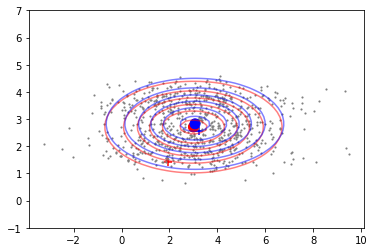

k 2 	alpha 0.5
p: 0.3 	mu_1: ( 2.9658825397491455 2.710045337677002 )	sigma_1: ( 1.31215238571167 1.3156894445419312 )	mu_2: ( 3.0624208450317383 2.820797920227051 	sigma_2: ( 1.3156894445419312 -0.28137344121932983 )


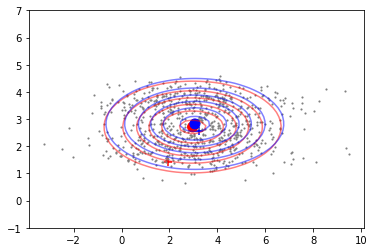

k 2 	alpha 0.7
p: 0.3 	mu_1: ( 2.681441068649292 2.691035509109497 )	sigma_1: ( 1.3572832345962524 1.350132703781128 )	mu_2: ( 2.9756858348846436 2.825624942779541 	sigma_2: ( 1.350132703781128 -0.2867661118507385 )


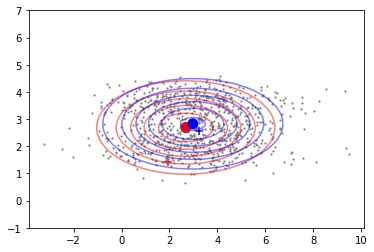

k 2 	alpha 0.9
p: 0.3 	mu_1: ( 1.1953319311141968 1.5609647035598755 )	sigma_1: ( 1.1104836463928223 1.7114231586456299 )	mu_2: ( 2.2953028678894043 2.7207095623016357 	sigma_2: ( 1.7114231586456299 0.16138790547847748 )


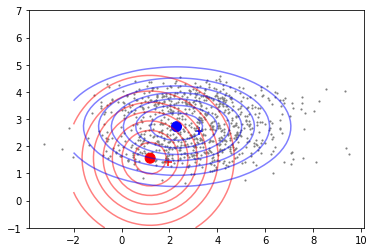

k 2 	alpha 1
p: 0.3 	mu_1: ( 0.0018358167726546526 -0.004497007466852665 )	sigma_1: ( -0.08238030970096588 0.07738477736711502 )	mu_2: ( -0.0003120769979432225 0.005203138571232557 	sigma_2: ( 0.07738477736711502 0.06028512120246887 )


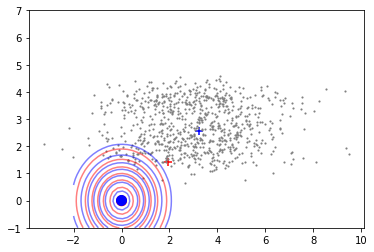

k 5 	alpha 0.0
p: 0.3 	mu_1: ( 2.891510009765625 2.668112277984619 )	sigma_1: ( 1.1471079587936401 1.4289171695709229 )	mu_2: ( 3.162177324295044 2.851987838745117 	sigma_2: ( 1.4289171695709229 -0.2904484272003174 )


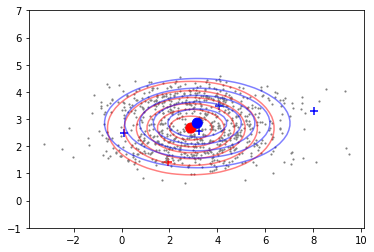

k 5 	alpha 0.1
p: 0.3 	mu_1: ( 2.882059335708618 2.6569786071777344 )	sigma_1: ( 1.1564639806747437 1.4183239936828613 )	mu_2: ( 3.166065216064453 2.858201503753662 	sigma_2: ( 1.4183239936828613 -0.292280912399292 )


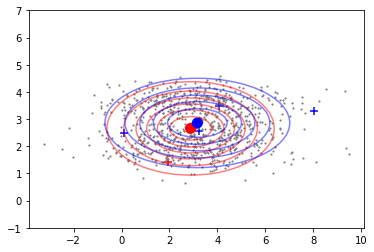

k 5 	alpha 0.3
p: 0.3 	mu_1: ( 2.8317694664001465 2.634287118911743 )	sigma_1: ( 1.1782081127166748 1.390527606010437 )	mu_2: ( 3.188338041305542 2.8655478954315186 	sigma_2: ( 1.390527606010437 -0.29566776752471924 )


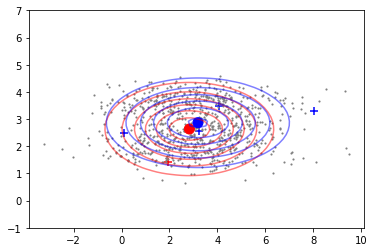

k 5 	alpha 0.5
p: 0.3 	mu_1: ( 2.6229817867279053 2.608218193054199 )	sigma_1: ( 1.2165253162384033 1.3345322608947754 )	mu_2: ( 3.2433290481567383 2.8550162315368652 	sigma_2: ( 1.3345322608947754 -0.2997400760650635 )


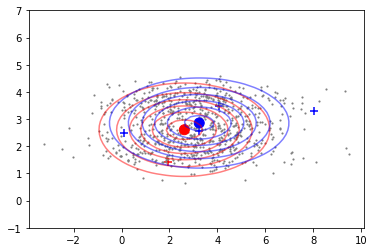

k 5 	alpha 0.7
p: 0.3 	mu_1: ( 1.877399206161499 2.3749868869781494 )	sigma_1: ( 1.2444342374801636 1.2815090417861938 )	mu_2: ( 3.207392454147339 2.835155725479126 	sigma_2: ( 1.2815090417861938 -0.3276507258415222 )


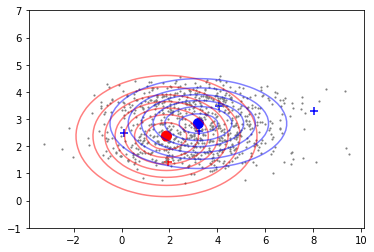

k 5 	alpha 0.9
p: 0.3 	mu_1: ( 0.6916462779045105 0.9677503108978271 )	sigma_1: ( 0.580352246761322 1.5827029943466187 )	mu_2: ( 2.4526121616363525 2.785144805908203 	sigma_2: ( 1.5827029943466187 -0.0011875620111823082 )


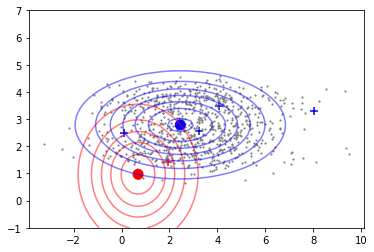

k 5 	alpha 1
p: 0.3 	mu_1: ( 0.020782357081770897 -0.07605983316898346 )	sigma_1: ( -0.08383028954267502 0.0782124325633049 )	mu_2: ( -0.01572970300912857 0.06823181360960007 	sigma_2: ( 0.0782124325633049 0.1414153128862381 )


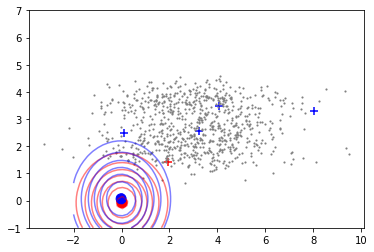

k 10 	alpha 0.0
p: 0.3 	mu_1: ( 2.8809456825256348 2.4276375770568848 )	sigma_1: ( 1.2074283361434937 1.38397216796875 )	mu_2: ( 3.1701598167419434 3.0542497634887695 	sigma_2: ( 1.38397216796875 -0.38391590118408203 )


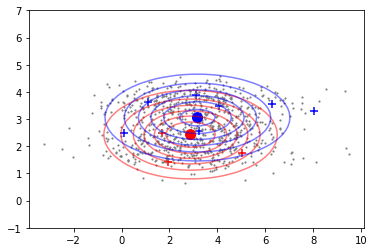

k 10 	alpha 0.1
p: 0.3 	mu_1: ( 2.87025785446167 2.427694082260132 )	sigma_1: ( 1.2069276571273804 1.380438208580017 )	mu_2: ( 3.173571825027466 3.042642116546631 	sigma_2: ( 1.380438208580017 -0.3764297068119049 )


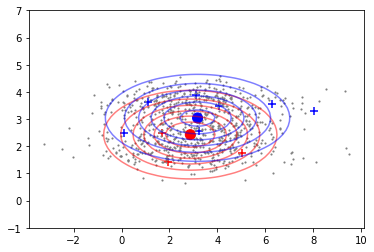

k 10 	alpha 0.3
p: 0.3 	mu_1: ( 2.8112246990203857 2.444124221801758 )	sigma_1: ( 1.205295443534851 1.368227481842041 )	mu_2: ( 3.197002649307251 2.9987130165100098 	sigma_2: ( 1.368227481842041 -0.3503260314464569 )


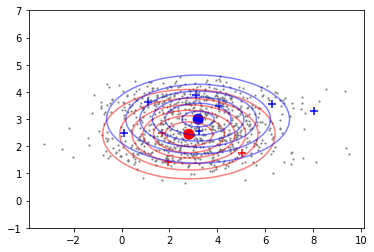

k 10 	alpha 0.5
p: 0.3 	mu_1: ( 2.5735886096954346 2.4832234382629395 )	sigma_1: ( 1.224808931350708 1.3235986232757568 )	mu_2: ( 3.252903938293457 2.9162991046905518 	sigma_2: ( 1.3235986232757568 -0.3174991309642792 )


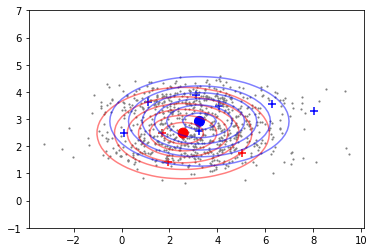

k 10 	alpha 0.7
p: 0.3 	mu_1: ( 1.8550608158111572 2.3037633895874023 )	sigma_1: ( 1.256040334701538 1.2799944877624512 )	mu_2: ( 3.206916570663452 2.8543827533721924 	sigma_2: ( 1.2799944877624512 -0.32975655794143677 )


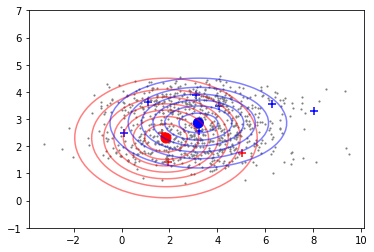

k 10 	alpha 0.9
p: 0.3 	mu_1: ( 0.9176819324493408 1.1232882738113403 )	sigma_1: ( 0.9381646513938904 1.6111778020858765 )	mu_2: ( 2.407564640045166 2.80153489112854 	sigma_2: ( 1.6111778020858765 0.04511680454015732 )


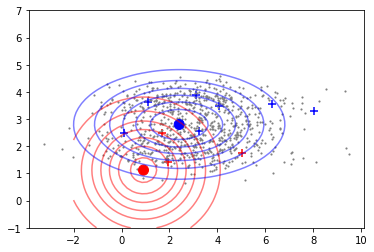

k 10 	alpha 1
p: 0.3 	mu_1: ( 0.13684998452663422 -0.007960397750139236 )	sigma_1: ( -0.038356613367795944 0.020513972267508507 )	mu_2: ( -0.14015667140483856 0.019310761243104935 	sigma_2: ( 0.020513972267508507 0.22146643698215485 )


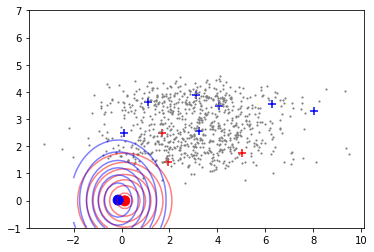

k 15 	alpha 0.0
p: 0.3 	mu_1: ( 2.928257942199707 2.084010601043701 )	sigma_1: ( 1.3161495923995972 1.3049719333648682 )	mu_2: ( 3.1271402835845947 3.3301286697387695 	sigma_2: ( 1.3049719333648682 -0.7624078989028931 )


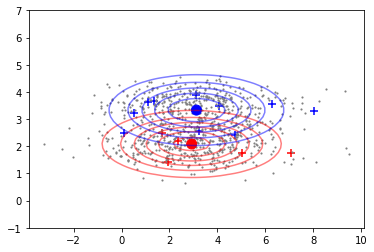

k 15 	alpha 0.1
p: 0.3 	mu_1: ( 2.9177706241607666 2.1300652027130127 )	sigma_1: ( 1.310865879058838 1.3084710836410522 )	mu_2: ( 3.1312506198883057 3.2690787315368652 	sigma_2: ( 1.3084710836410522 -0.6437579393386841 )


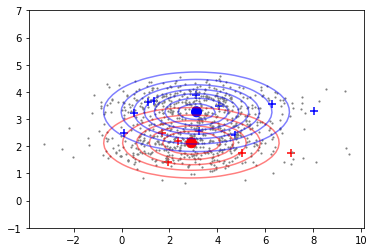

k 15 	alpha 0.3
p: 0.3 	mu_1: ( 2.865180730819702 2.2480685710906982 )	sigma_1: ( 1.3019380569458008 1.31217622756958 )	mu_2: ( 3.152834415435791 3.1320977210998535 	sigma_2: ( 1.31217622756958 -0.464324027299881 )


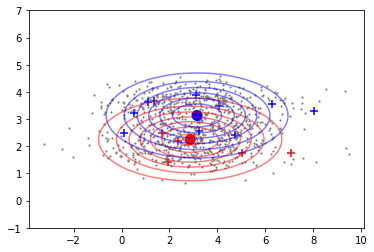

k 15 	alpha 0.5
p: 0.3 	mu_1: ( 2.662032127380371 2.364488124847412 )	sigma_1: ( 1.3311686515808105 1.2863478660583496 )	mu_2: ( 3.203166961669922 2.9877445697784424 	sigma_2: ( 1.2863478660583496 -0.35667186975479126 )


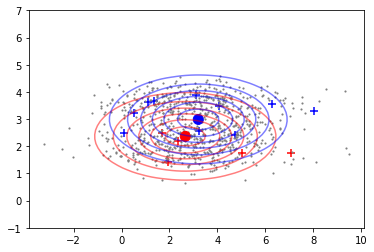

k 15 	alpha 0.7
p: 0.3 	mu_1: ( 2.0214216709136963 2.308098793029785 )	sigma_1: ( 1.455965280532837 1.2547684907913208 )	mu_2: ( 3.169550657272339 2.887240171432495 	sigma_2: ( 1.2547684907913208 -0.34241989254951477 )


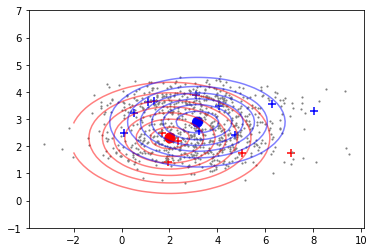

k 15 	alpha 0.9
p: 0.3 	mu_1: ( 1.127577781677246 1.3210594654083252 )	sigma_1: ( 1.458093523979187 1.591135859489441 )	mu_2: ( 2.341735601425171 2.813474655151367 	sigma_2: ( 1.591135859489441 0.11389368772506714 )


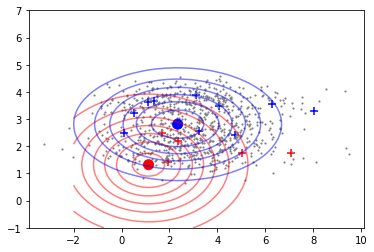

k 15 	alpha 1
p: 0.3 	mu_1: ( 0.16692125797271729 0.016498208045959473 )	sigma_1: ( -0.03591471537947655 0.0058121089823544025 )	mu_2: ( -0.18344061076641083 0.011404001154005527 	sigma_2: ( 0.0058121089823544025 0.2735859155654907 )


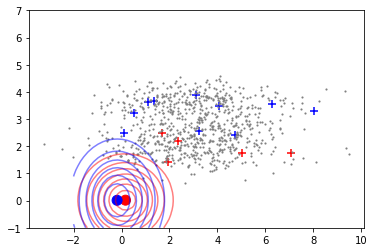

k 20 	alpha 0.0
p: 0.3 	mu_1: ( 2.9252400398254395 2.0186047554016113 )	sigma_1: ( 1.3186527490615845 1.30301034450531 )	mu_2: ( 3.1330275535583496 3.4311227798461914 	sigma_2: ( 1.30301034450531 -1.1073834896087646 )


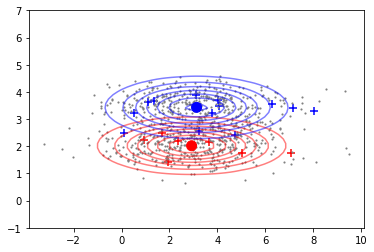

k 20 	alpha 0.1
p: 0.3 	mu_1: ( 2.9082372188568115 2.021944761276245 )	sigma_1: ( 1.3159979581832886 1.303857445716858 )	mu_2: ( 3.1400225162506104 3.387986898422241 	sigma_2: ( 1.303857445716858 -0.9531038403511047 )


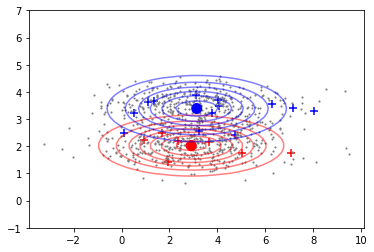

k 20 	alpha 0.3
p: 0.3 	mu_1: ( 2.8264060020446777 2.1069326400756836 )	sigma_1: ( 1.2937583923339844 1.3131235837936401 )	mu_2: ( 3.174379587173462 3.2286674976348877 	sigma_2: ( 1.3131235837936401 -0.5978839993476868 )


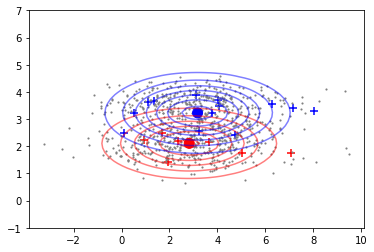

k 20 	alpha 0.5
p: 0.3 	mu_1: ( 2.5591635704040527 2.2948524951934814 )	sigma_1: ( 1.2976971864700317 1.2920105457305908 )	mu_2: ( 3.240022659301758 3.0101592540740967 	sigma_2: ( 1.2920105457305908 -0.3719988167285919 )


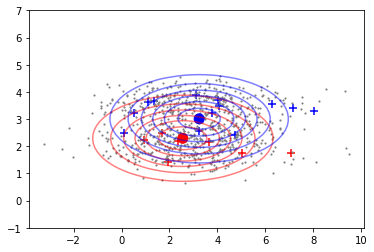

k 20 	alpha 0.7
p: 0.3 	mu_1: ( 1.9297839403152466 2.243830919265747 )	sigma_1: ( 1.4013762474060059 1.2587385177612305 )	mu_2: ( 3.193701982498169 2.899967908859253 	sigma_2: ( 1.2587385177612305 -0.3430352509021759 )


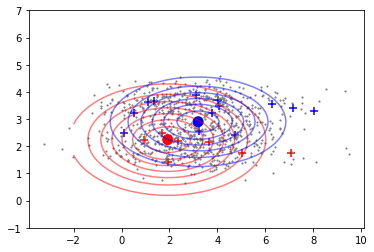

k 20 	alpha 0.9
p: 0.3 	mu_1: ( 1.1980793476104736 1.426068663597107 )	sigma_1: ( 1.4430210590362549 1.623930811882019 )	mu_2: ( 2.3165290355682373 2.817230463027954 	sigma_2: ( 1.623930811882019 0.1631394624710083 )


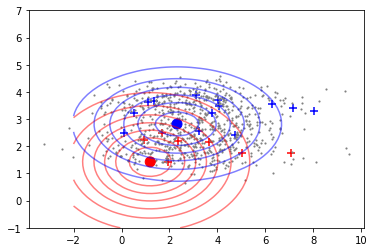

k 20 	alpha 1
p: 0.3 	mu_1: ( 0.21452254056930542 0.10175029188394547 )	sigma_1: ( -0.0693616047501564 0.020443854853510857 )	mu_2: ( -0.24101372063159943 -0.04929700121283531 	sigma_2: ( 0.020443854853510857 0.30679449439048767 )


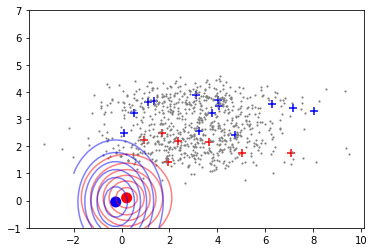

k 50 	alpha 0.0
p: 0.3 	mu_1: ( 2.9672324657440186 2.058211088180542 )	sigma_1: ( 1.3119012117385864 1.3119826316833496 )	mu_2: ( 3.1114556789398193 3.5255494117736816 	sigma_2: ( 1.3119826316833496 -1.504381537437439 )


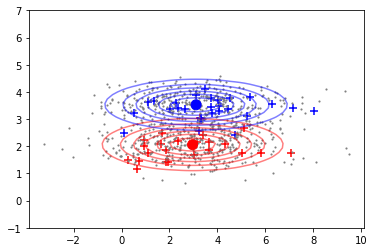

k 50 	alpha 0.1
p: 0.3 	mu_1: ( 2.9600155353546143 2.047882556915283 )	sigma_1: ( 1.312723159790039 1.3107768297195435 )	mu_2: ( 3.115489959716797 3.512255907058716 	sigma_2: ( 1.3107768297195435 -1.4597703218460083 )


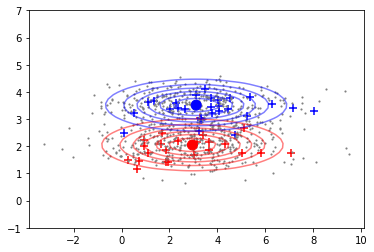

k 50 	alpha 0.3
p: 0.3 	mu_1: ( 2.9291625022888184 2.023310661315918 )	sigma_1: ( 1.3149878978729248 1.307688593864441 )	mu_2: ( 3.129035234451294 3.4732110500335693 	sigma_2: ( 1.307688593864441 -1.3069854974746704 )


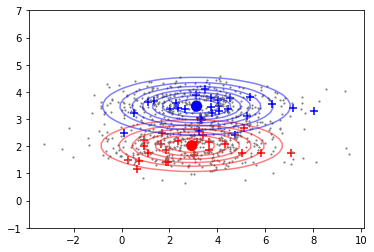

k 50 	alpha 0.5
p: 0.3 	mu_1: ( 2.7767508029937744 2.007199287414551 )	sigma_1: ( 1.3166695833206177 1.3039448261260986 )	mu_2: ( 3.1757426261901855 3.3714542388916016 	sigma_2: ( 1.3039448261260986 -0.9175634980201721 )


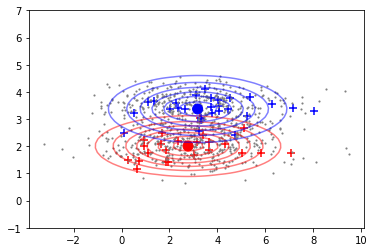

k 50 	alpha 0.7
p: 0.3 	mu_1: ( 2.3304660320281982 2.098914384841919 )	sigma_1: ( 1.3526594638824463 1.309262752532959 )	mu_2: ( 3.165994167327881 3.178934335708618 	sigma_2: ( 1.309262752532959 -0.5536115169525146 )


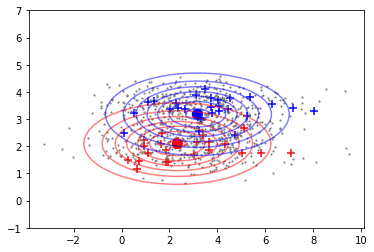

k 50 	alpha 0.9
p: 0.3 	mu_1: ( 1.6664466857910156 1.9406722784042358 )	sigma_1: ( 1.5296624898910522 1.8045032024383545 )	mu_2: ( 2.0443663597106934 2.7109756469726562 	sigma_2: ( 1.8045032024383545 0.61873459815979 )


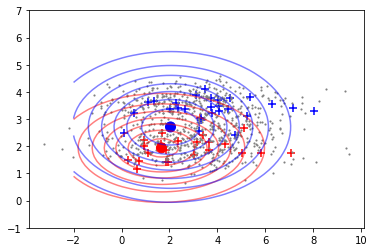

k 50 	alpha 1
p: 0.3 	mu_1: ( 0.3939892053604126 0.3959997892379761 )	sigma_1: ( -0.15363870561122894 0.05395058915019035 )	mu_2: ( -0.5002180337905884 -0.24164056777954102 	sigma_2: ( 0.05395058915019035 0.46264374256134033 )


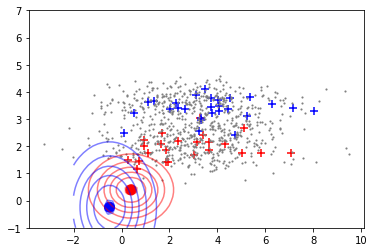

In [77]:
for k in [2,5,10, 15, 20, 50]:
  for alpha in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]:
    print("k", k, "\talpha", alpha)
    for_interactionBishop(alpha,k)

In [10]:
minus_L(theta0)

TypeError: ignored